1 Epcoh = 30 iterations
Iteration 0, Training Loss: 3.6893603801727295  Validation Loss: 3.7244327068328857
Iteration 30, Training Loss: 2.634793996810913  Validation Loss: 2.6552462577819824
Iteration 60, Training Loss: 2.5244972705841064  Validation Loss: 2.526118755340576
Iteration 90, Training Loss: 2.49685001373291  Validation Loss: 2.501718521118164
Iteration 120, Training Loss: 2.477557420730591  Validation Loss: 2.489208221435547
Iteration 150, Training Loss: 2.4568700790405273  Validation Loss: 2.4752047061920166
Iteration 180, Training Loss: 2.4341161251068115  Validation Loss: 2.456688642501831
Iteration 210, Training Loss: 2.40153431892395  Validation Loss: 2.431591510772705
Iteration 240, Training Loss: 2.358245611190796  Validation Loss: 2.398949146270752
Iteration 270, Training Loss: 2.300971269607544  Validation Loss: 2.3481833934783936
Iteration 300, Training Loss: 2.230426549911499  Validation Loss: 2.284477949142456
Iteration 330, Training Loss: 2.1577136516571045  V

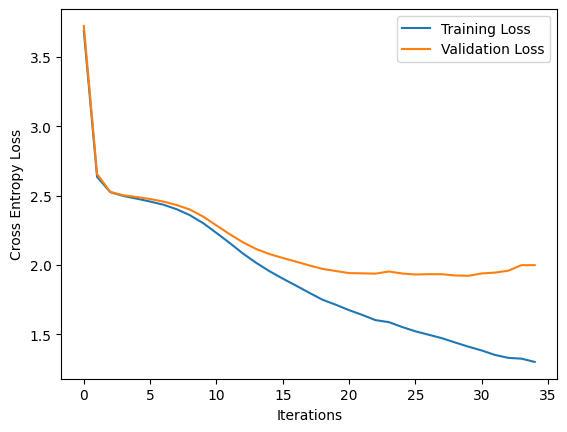

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from dataclasses import dataclass

# loading the dataset
with open('/kaggle/input/shakespeare/data.txt','r') as f:
    text = f.read()

chars = sorted(list(set(text)))
vocab_size = len(chars)

# dictionaries
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}

# simple character level encoding
def encode(s):
    ''' Inputs a string and outputs a list of indices'''
    return [stoi[ch] for ch in s]

def decode(enc):
    ''' Inputs a list of indices and outputs a string'''
    return ''.join(itos[i] for i in enc)

data = torch.tensor(encode(text))

n = data.shape[0]
# splitting data: 90% and 10%
data_train = data[:int(n*0.9)]
data_val = data[int(n*0.9):]

# hyperparameters

device = 'cuda' if torch.cuda.is_available() else 'cpu'
alpha = 3e-4

torch.set_default_device(device)

@dataclass
class Config():
    context_length: int = 256
    batch_size: int = 128
    n_emb: int = 384     # 6 * 64
    n_heads: int = 6
    n_layers: int = 6
    dropout_ratio: float = 0.25


# a simple dataloader
class DataLoader():

    def __init__(self,batch_size,context_length,cont = 'train'):
        
        self.mydata = data_train if cont=='train' else data_val
        self.B = batch_size
        self.T = context_length
        self.currentState = 0
        self.niter = len(self.mydata) // (self.B * context_length)
#         print(f"1 Epcoh = {self.niter} iterations")

    def get_batch(self):
        
        chunk = self.mydata[self.currentState:self.currentState + (self.B * self.T)+1]

        Xb = chunk[:-1].view(self.B,self.T)
        Yb = chunk[1:].view(self.B,self.T)
        Xb = Xb.to(device)
        Yb = Yb.to(device)
        
        self.currentState += (self.B * self.T) 

        if self.currentState + (self.B * self.T) + 1 > len(self.mydata):
            self.currentState = 0
        
        return Xb, Yb


class CausalSelfAttention(nn.Module):

    def __init__(self,config):

        assert config.n_emb % config.n_heads == 0, "Number of heads must divide the number of embeddings"
        
        super().__init__()

        self.config = config
        self.c_attn = nn.Linear(self.config.n_emb,self.config.n_emb*3)
        self.proj = nn.Linear(self.config.n_emb,self.config.n_emb)
        self.dropout = nn.Dropout(self.config.dropout_ratio)

    def forward(self,x):
        
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.config.n_emb,dim=-1)

        B, T, C = x.shape
        # From [batch, sequence, features] to [batch, heads, sequence, features]   -- by GPT2 OpenAI repo
        # converting to 4D tensors (B,nH,T,head_size)
        k = k.view(B,T,self.config.n_heads, C // self.config.n_heads ).transpose(1,2) 
        v = v.view(B,T,self.config.n_heads, C // self.config.n_heads ).transpose(1,2)
        q = q.view(B,T,self.config.n_heads, C // self.config.n_heads ).transpose(1,2)
        
        # flash attention: much more faster than writing attention code in 4 steps
        y = F.scaled_dot_product_attention(q, k, v, is_causal=True) 
        
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        
        # output projection
        y = self.proj(y)
        
        return y



class FeedForward(nn.Module):

    def __init__(self,config):

        super().__init__()

        self.config = config
        self.mlp = nn.Sequential(
            nn.Linear(self.config.n_emb,4 * self.config.n_emb),
            nn.ReLU(),
            nn.Linear(4 * self.config.n_emb,self.config.n_emb),
            nn.Dropout(self.config.dropout_ratio)
        )

    def forward(self,x):
        return self.mlp(x)


class Block(nn.Module):
    ''' Transformer Block: Communication & Computation'''

    def __init__(self,config):
        super().__init__()
        
        self.config = config
        self.msa_head = CausalSelfAttention(self.config)
        self.feedfwd = FeedForward(self.config)
        self.ln1 = nn.LayerNorm(self.config.n_emb)
        self.ln2 = nn.LayerNorm(self.config.n_emb)

    def forward(self,x):

        # normalization is not applied at residual connections
        x = x + self.msa_head(self.ln1(x))
        x = x + self.feedfwd(self.ln2(x))

        return x
        

class LanguageModel(nn.Module):

    def __init__(self,config):
        super().__init__()
        self.config = config
        self.token_emb = nn.Embedding(vocab_size,self.config.n_emb)
        self.position_emb = nn.Embedding(self.config.context_length,self.config.n_emb)
        self.blocks = nn.Sequential(*[Block(self.config) for _ in range(self.config.n_layers)])
        self.ln = nn.LayerNorm(self.config.n_emb)
        self.lin_head = nn.Linear(self.config.n_emb,vocab_size)

    def forward(self,x,targets = None):
        
        # B - number of batches, T - context-length, E - number of embeddings, C- channel size - voacb_size
        # x,targets: type of BxT
        
        # for generation in the beginning T != context_length
        T = x.shape[1]
        
        tok = self.token_emb(x)    # (B,T,E)
        pos = self.position_emb(torch.arange(T))       # TxE
        # info contains both information of position and character(token)
        x = tok + pos  # BxTxE  
        x = self.blocks(x)
        x = self.ln(x)
        logits = self.lin_head(x)        # BxTxC

        if targets != None:
            B, T, C = logits.shape
            logits = logits.view(B*T,C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits,targets)
        else:
            loss = None

        return logits,loss

    def generate(self,x,max_len):
        
        for i in range(max_len):
            
            # x: (B,T) --indexes
            # x.shape[1] should not surpass context-length
            
            logits,_ = self(x[:,-self.config.context_length:])    # (B,T,C)
            # we only need the logits of the last character -- in Bigram model
            logits = logits[:,-1,:]      #(B,C)
            probs = F.softmax(logits,dim=-1)
            # return indices
            next_char = torch.multinomial(probs,num_samples=1)   #(B,1)
            x = torch.cat((x,next_char),dim=1)

        return x


@torch.no_grad()
def get_eval_loss():

    model.eval()    # turns on evaluation mode of the model
    losses = {}

    for cont in ['train','val']:
        dtl = DataLoader(Config.batch_size,Config.context_length,cont)
        losses_track = torch.zeros(dtl.niter)
        for i in range(dtl.niter):
            xb,yb = dtl.get_batch()
            _, loss = model(xb,yb)
            losses_track[i] = loss.item()
        losses[cont] = losses_track.mean().item()
    
    model.train()   # turns on training mode of the model

    return losses

model = LanguageModel(Config())
model.to(device)

# Pytorch optimizer
optimizer = torch.optim.AdamW(model.parameters(),lr=alpha)

loss_tr = []
loss_val = []

def train(max_iterations):

    dtl = DataLoader(Config.batch_size,Config.context_length,'train')
    intervals = dtl.niter
    print(f"1 Epcoh = {intervals} iterations")

    for i in range(max_iterations):
        xb,yb = dtl.get_batch()
        _, loss = model(xb,yb)
        optimizer.zero_grad(set_to_none=True)     # sets to None instead of 0
        loss.backward()
        optimizer.step()

        if i %  intervals == 0 or i == (max_iterations-1):
            losses = get_eval_loss()
            loss_tr.append(losses['train'])
            loss_val.append(losses['val'])
            print(f"Iteration {i}, Training Loss: {losses['train']}  Validation Loss: {losses['val']}")


    losses = get_eval_loss()
    print("Final Training Loss: ",losses['train'])
    print("Final Validation Loss: ",losses['val'])

train(1000)   

plt.plot(loss_tr, label="Training Loss")
plt.plot(loss_val, label="Validation Loss")
plt.xlabel('Iterations')
plt.ylabel('Cross Entropy Loss')
plt.legend()

torch.save(model.state_dict(),'transformer_model.pth')